In [1]:
import pydicom as dicom
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Importamos imágenes

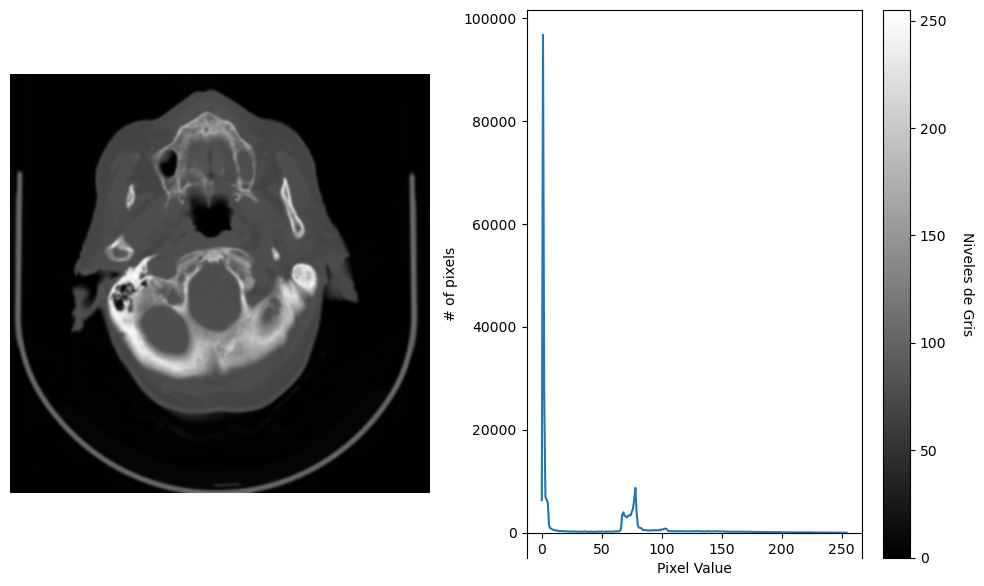

In [2]:
def open_image(path_to_image):
    ds = dicom.dcmread(path_to_image)
    return ds.pixel_array

def im_uint8(image):
    return (image / np.max(image) * 255).astype(np.uint8)


PATH = os.path.join('C://Users\Mario\DataSpell Projects\segmentation_biomed\DICOM_image', 'im1.dcm')
pixel_data = open_image(PATH)
pixel_data_uint8 = im_uint8(pixel_data)

def histogram_image(image):
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    #Plot the image
    im = axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')
    bins = np.max(image)
    # Plot the histogram
    hist = cv2.calcHist([image], [0], None, [bins], [0, bins])
    axes[1].plot(hist)
    axes[1].set_xlabel("Pixel Value")
    axes[1].set_ylabel("# of pixels")
    # Move the x-axis to y=0
    axes[1].spines['bottom'].set_position('zero')
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Niveles de Gris', rotation=270, labelpad=20)
    plt.tight_layout()
    plt.show()
    return None

histogram_image(pixel_data_uint8)

### Visualización de máscaras superpuestas

In [3]:
def overlay_mask_on_image(image, mask, color=(255, 0, 0)):
    # Create a 3-channel version of the grayscale image
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Identify where the mask is active
    active_pixels = (mask == 255)

    # Apply color to the active mask regions in the image
    color_image[active_pixels] = color

    return color_image

### Visualizacióm completa: Imagen, máscara, máscara superpuesta

In [4]:
def visualize(image, mask, color=(255, 0, 0)):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    overlay = overlay_mask_on_image(image, mask, color=color)
    plt.subplot(1, 3, 3)
    plt.imshow(overlay, cmap='gray')
    plt.title('Overlayed mask on image')
    plt.axis('off')
    
    plt.show()

#### Umbralización manual

In [50]:
def umbralizacion_manual(img, lower_bound, upper_bound=255):
    # Inicializamos una imagen de ceros con el tamaño de la imagen de entrada
    thresholded_image = np.zeros_like(img)
    # Thresholding manual
    thresholded_image[(img >= lower_bound) & (img <= upper_bound)] = 255  # Setting pixels in the ROI to white
    return thresholded_image

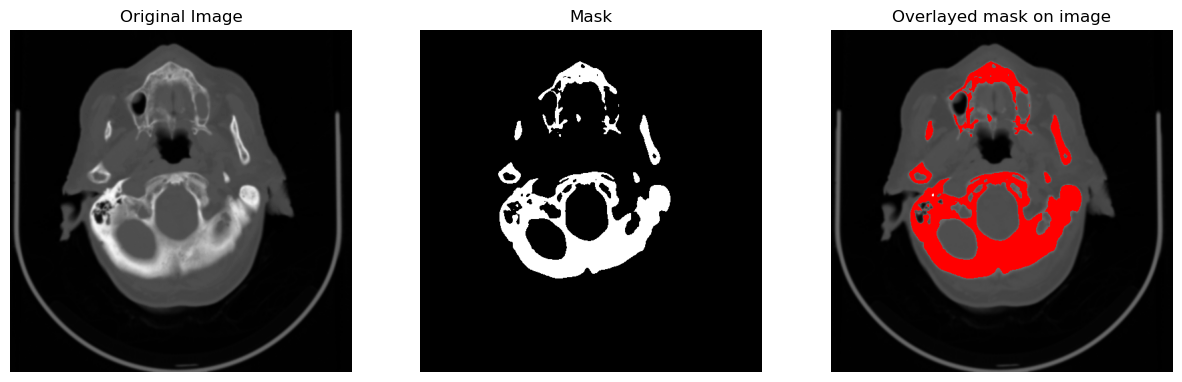

In [96]:
masked_im1 = umbralizacion_manual(pixel_data_uint8, 110, upper_bound=250)
visualize(pixel_data_uint8, masked_im1)

#### Umbralización iterativa

In [52]:
def iterative_thresholding(image, dt=1e-5):
    # Paso 1: Seleccionar un umbral inicial T como la media de todos los píxeles en la imagen
    t = np.mean(image)
    while True:
        # Paso 2: Aplicar la umbralización para obtener dos grupos de píxeles G1 y G2
        g1 = image[image < t]
        g2 = image[image >= t]
        # Paso 3: Calcular el valor medio (m1 y m2) de los grupos G1 y G2
        m1 = np.mean(g1)
        m2 = np.mean(g2)
        # Paso 4: Calcular un nuevo umbral promediando m1 y m2
        new_t = (m1 + m2) / 2
        # Comprobar si la diferencia entre los dos T sucesivos es menor que dT
        if abs(new_t - t) < dt:
            break
        # Actualizar el valor de T para la siguiente iteración
        t = new_t
    # Inicializar una imagen en blanco y negro con ceros (negro)
    thresholded_image = np.zeros_like(image)
    # Aplicar el umbral para segmentar la imagen en dos grupos
    # Asignamos 255 (blanco) a los píxeles que tienen una intensidad mayor o igual a T
    thresholded_image[image >= t] = 255
    return thresholded_image, t

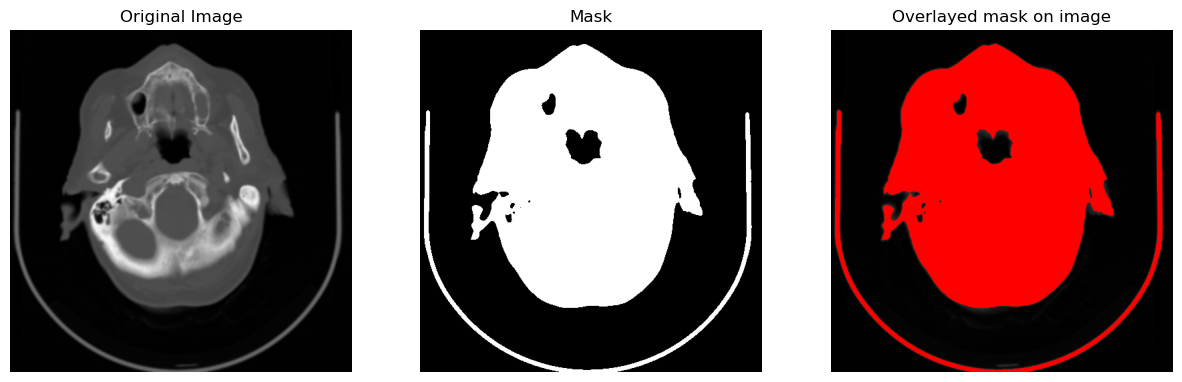

In [53]:
# Aplicamos umbralización utilizando la umbralización manual pero con el valor obtenido del algoritmo iterativo
masked_im2, umbral = iterative_thresholding(pixel_data_uint8)
visualize(pixel_data_uint8, masked_im2)

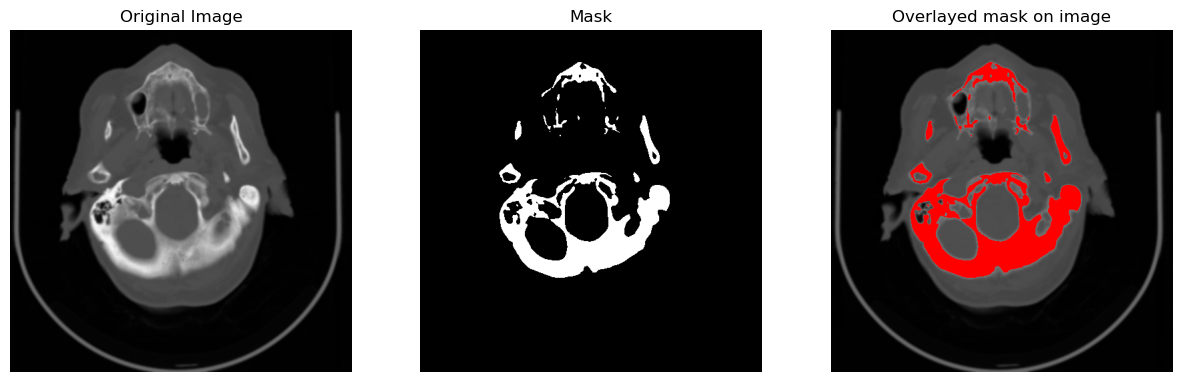

In [133]:
def iterative_thresholding_with_mask(image, mask, dt=1e-5):
    # Solo consideramos los píxeles donde la máscara tiene valor 255
    image_region = image[mask == 255]

    mascara, t = iterative_thresholding(image_region)

    # Inicializamos la imagen de salida con ceros
    thresholded_image = np.zeros_like(image)

    # Solo actualizamos los píxeles que pertenecen a la región de interés en la imagen de salida
    thresholded_image[mask == 255] = (image[mask == 255] >= t) * 255
    return thresholded_image, t

masked_im2, umbral = iterative_thresholding(pixel_data_uint8)
masked_im3, umbral = iterative_thresholding_with_mask(pixel_data_uint8, masked_im2)
visualize(pixel_data_uint8, masked_im3)

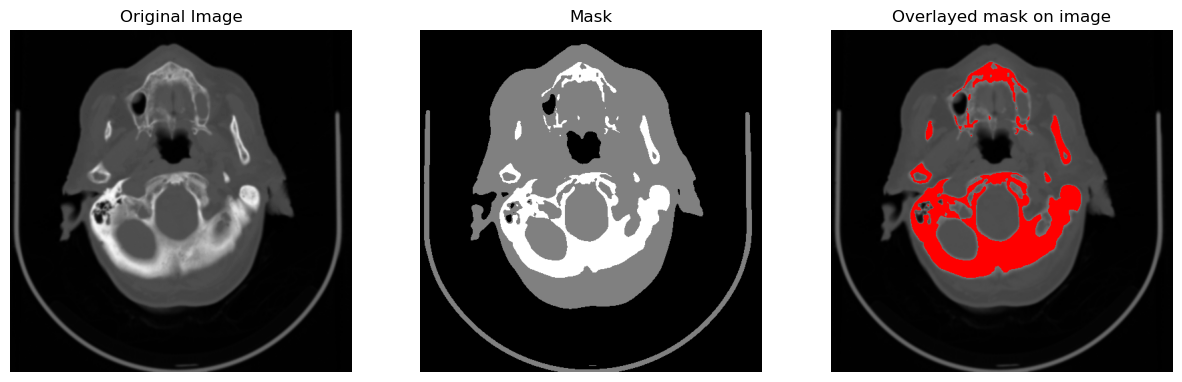

In [147]:
def k_umbrales(image, N, dt=1e-5):
    # Paso 1: Inicializar N-1 umbrales de manera uniforme en el rango de intensidades de la imagen
    ts = np.linspace(np.min(image), np.max(image), N+1)[1:-1]

    means = np.zeros(N)
    new_ts = np.zeros_like(ts)

    while True:
        # Paso 2: Segmentar la imagen en N grupos basados en los N-1 umbrales
        segments = [image[(image >= (ts[i-1] if i > 0 else np.min(image))) & (image < ts[i])] for i in range(N-1)]
        segments.append(image[image >= ts[-1]])

        # Paso 3: Calcular la media de cada grupo
        for i in range(N):
            means[i] = np.mean(segments[i])

        # Paso 4: Actualizar cada umbral basándose en las medias de sus grupos vecinos
        for i in range(N-1):
            new_ts[i] = (means[i] + means[i+1]) / 2

        # Comprobar si la actualización de todos los umbrales es menor que dT
        if np.all(np.abs(new_ts - ts) < dt):
            break

        ts = new_ts.copy()

    # Paso 5: Umbralizar la imagen en función de los umbrales actualizados
    thresholded_image = np.zeros_like(image)
    for i in range(N-1):
        thresholded_image[(image >= (ts[i-1] if i > 0 else np.min(image))) & (image < ts[i])] = 255 * (i+1) // N
    thresholded_image[image >= ts[-1]] = 255

    return thresholded_image, ts

masked_im4, umbral = k_umbrales(pixel_data_uint8, 3)
visualize(pixel_data_uint8, masked_im4)

In [54]:
def threshold_otsu(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_image

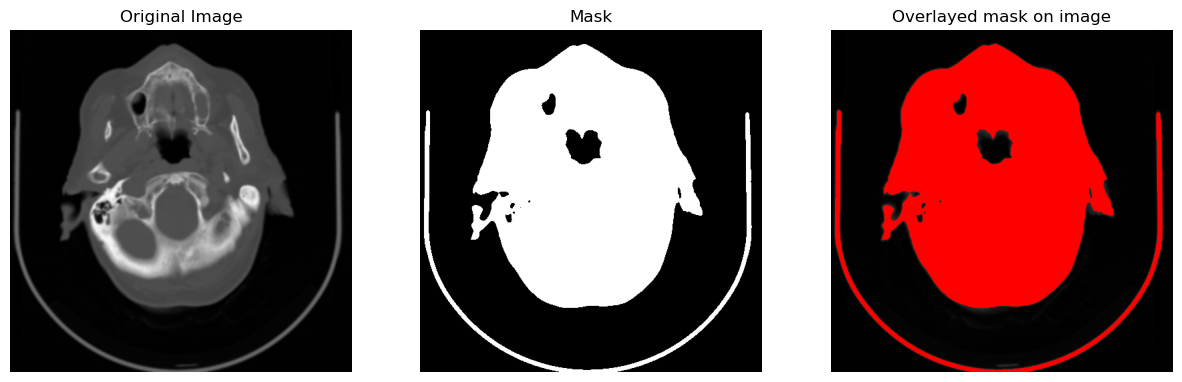

In [55]:
visualize(pixel_data_uint8, threshold_otsu(pixel_data_uint8))

In [6]:
def adaptive_gaussian_thresholding(image):
    """
    Aplica la umbralización adaptativa gaussiana a una imagen usando OpenCV.
    Args:
    - image_path (str): Ruta de la imagen que se desea procesar.
    Returns:
    - thresholded_image (np.array): Imagen umbralizada.
    """
    # Aplicar la umbralización adaptativa gaussiana
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY, 11, 2)
    return 255 - thresholded_image

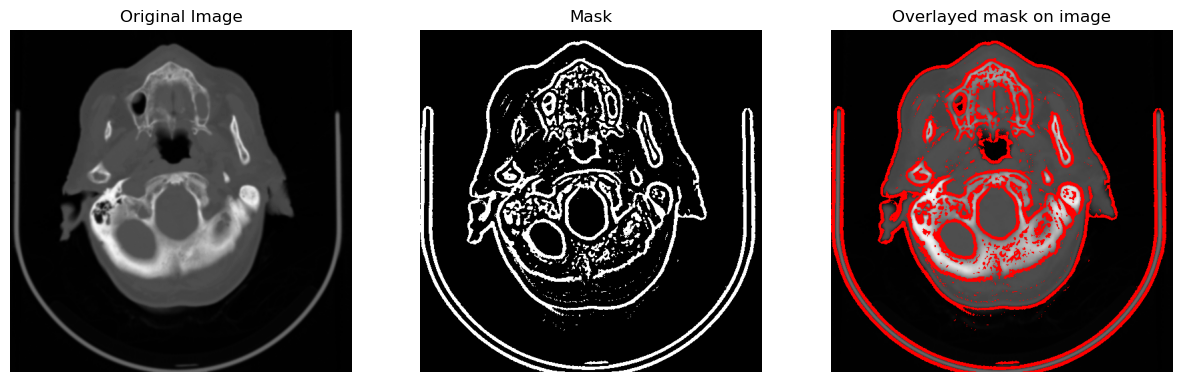

In [7]:
visualize(pixel_data_uint8, adaptive_gaussian_thresholding(pixel_data_uint8))

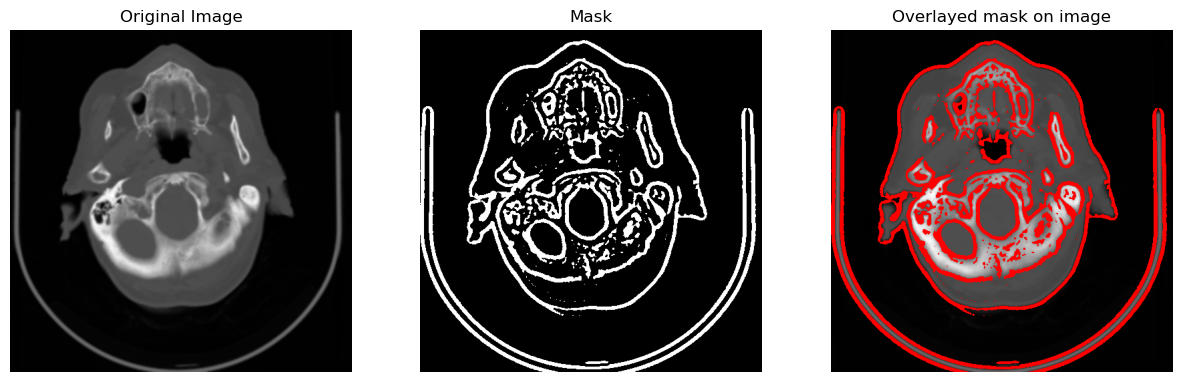

In [18]:
# Mi implementación
from gaussian_adaptative_custom import CustomGaussianThresholding

gau = CustomGaussianThresholding(pixel_data_uint8, sigma=11//2, window_size=11, c=4)
visualize(pixel_data_uint8, 255 - gau.apply_threshold())

Vamos a probar una cosita de morfología matemática...

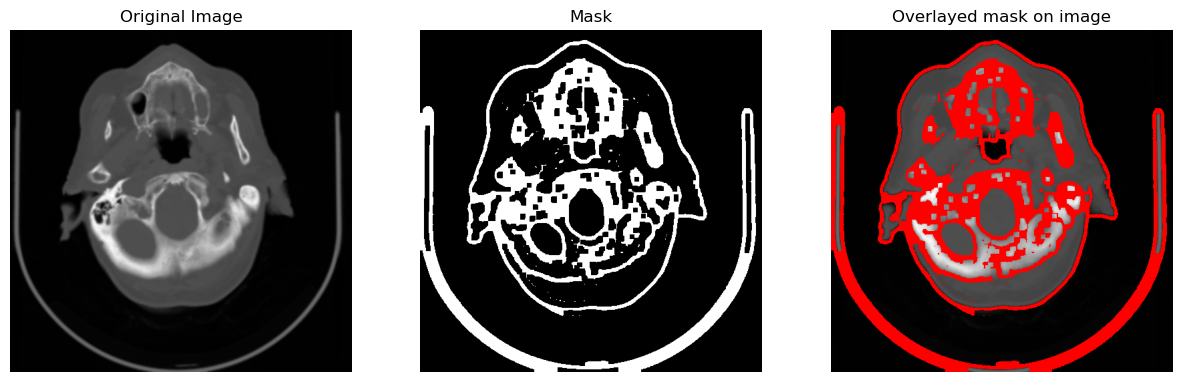

In [23]:
def morphological_closing(image, kernel_size):
    """
    Aplica una operación morfológica de cierre a la imagen utilizando un tamaño de kernel especificado.
    
    Parámetros:
    - image: Imagen de entrada en escala de grises.
    - kernel_size: Tamaño del kernel para la operación morfológica.
    
    Retorna:
    - closed_img: Imagen después de aplicar la operación de cierre.
    """

    # Crear el kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Aplicar la operación morfológica de cierre
    closed_img = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    return closed_img

image = 255 - gau.apply_threshold()
closed_image = morphological_closing(image, kernel_size=6)
visualize(pixel_data_uint8, closed_image)

In [97]:
def adaptive_mean_thresholding(image, block_size, C):
    result = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return result

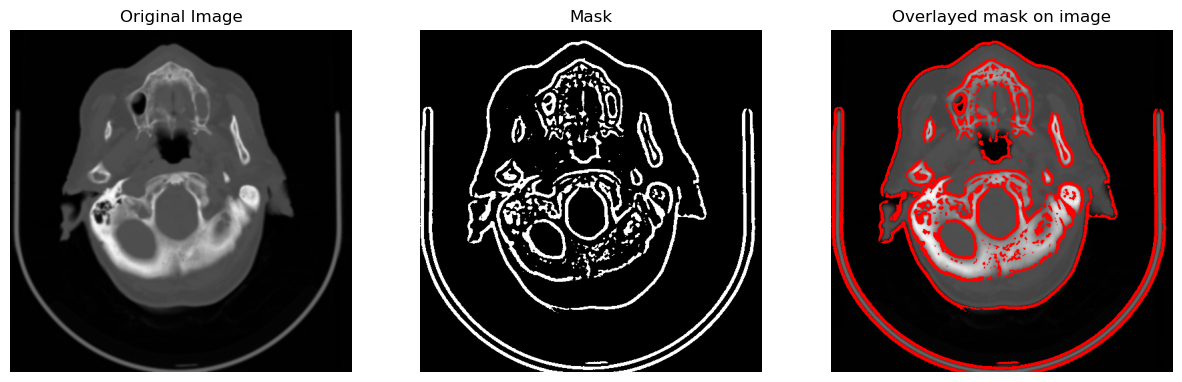

In [98]:
visualize(pixel_data_uint8, 255 - adaptive_mean_thresholding(pixel_data_uint8, 9, 4))

### Probamos a reducir el ruido primero

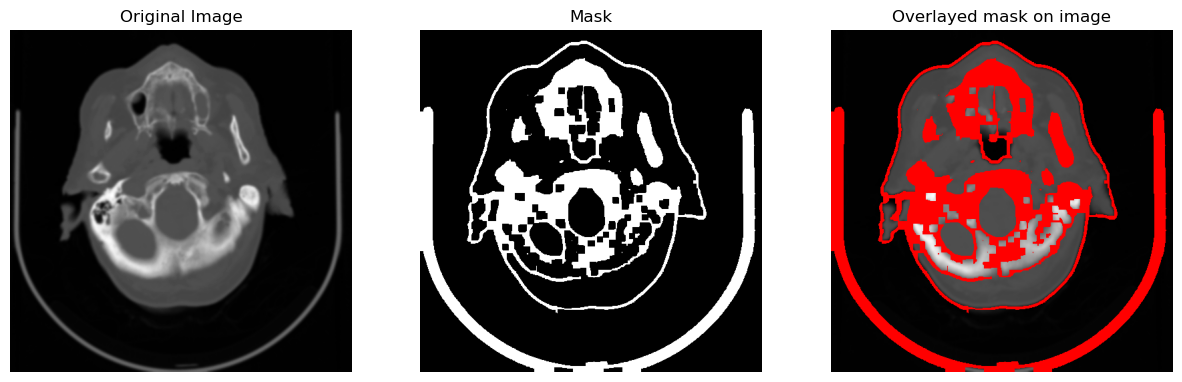

In [122]:
from image_preproc import Preprocess

prep = Preprocess(pixel_data_uint8)
prep.normalize(dtype=np.uint8)
prep.gaussian_filter(kernel_size=9, sigma=1)
denoised = prep.convolve(prep.gaussian)

gau = CustomGaussianThresholding(denoised, window_size=7, c=2)
closed_image = morphological_closing(255 - gau.apply_threshold(), kernel_size=9)
visualize(denoised, closed_image)

## Superpíxels

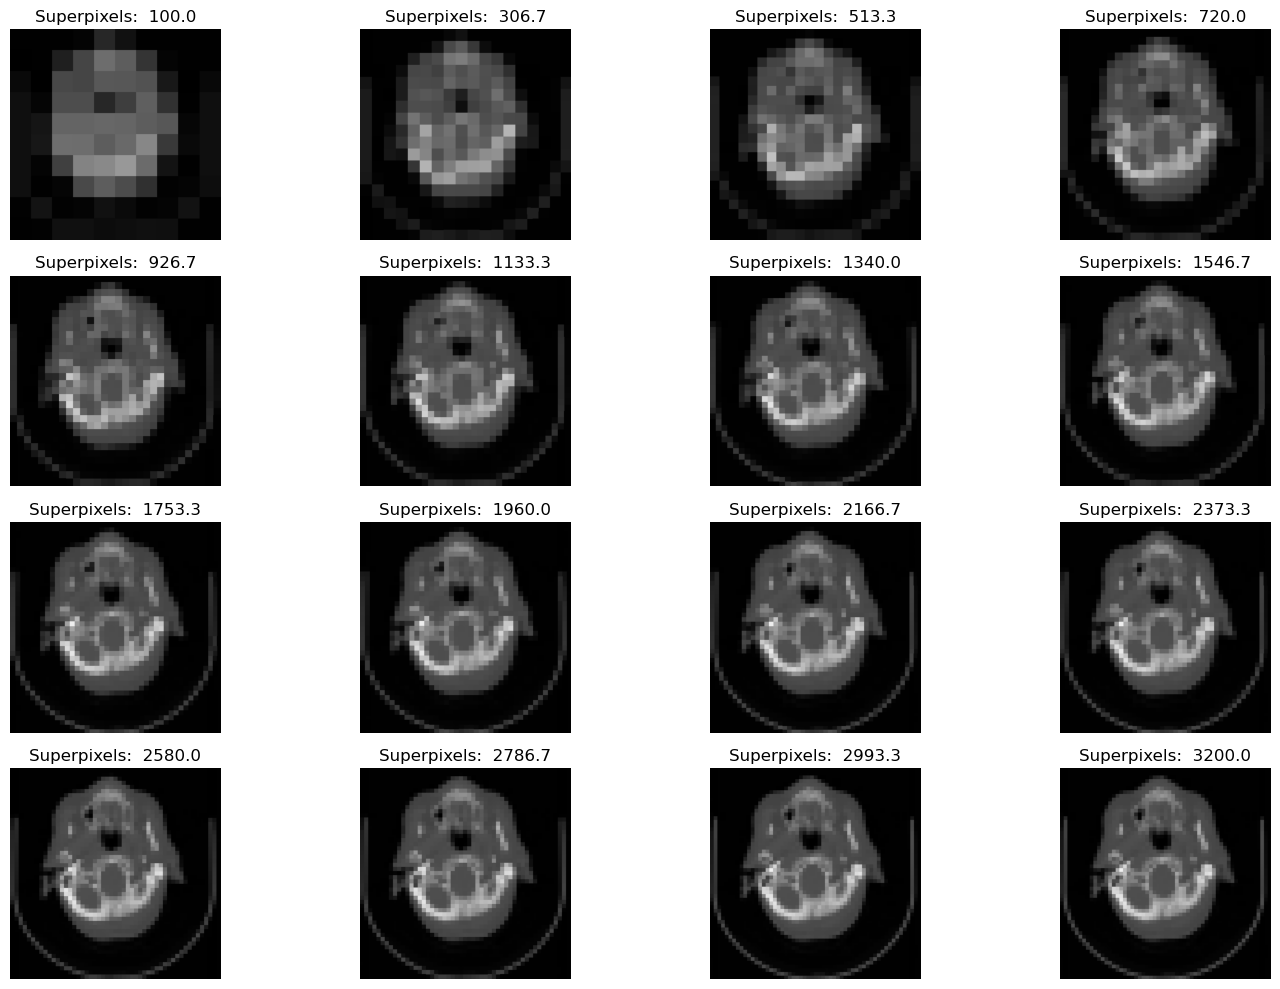

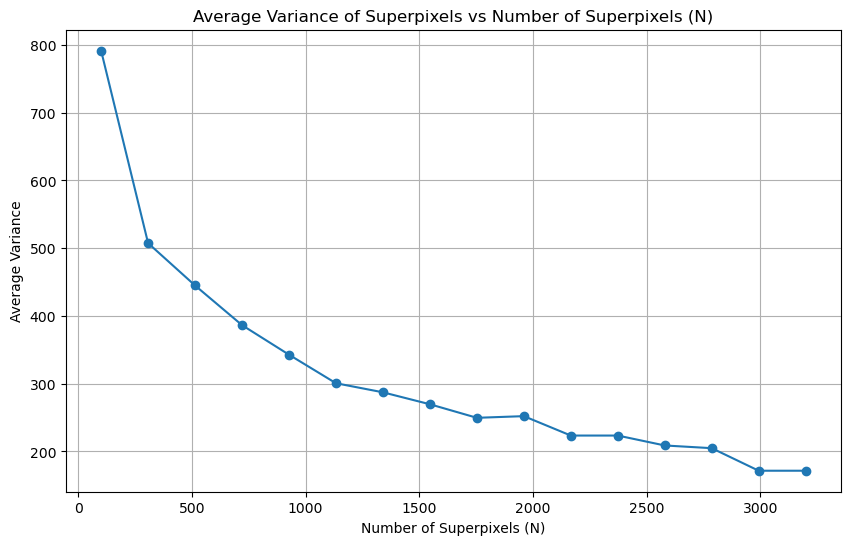

(2993.333333333333, 171.5670882053005)

In [5]:
from skimage.segmentation import slic
from skimage.color import label2rgb

# Function to find the optimal number of superpixels and perform segmentation
def slic_images(image, n_segments_list):
    """
    Finds the optimal number of superpixels for bone tissue segmentation and performs the segmentation.
    
    Parameters:
    - image (np.ndarray): The input grayscale image.
    - n_segments_list (list): List of number of superpixels to try for finding the optimal value.
    
    Returns:
    - dict: Dictionary containing the segmented images with different number of superpixels.
    """
    segmented_images = {}
    for n_segments in n_segments_list:
        # Perform SLIC segmentation to generate superpixels
        segments = slic(image, n_segments=n_segments, sigma=1)

        # Convert the segments to a labeled RGB image for visualization
        segmented_image = label2rgb(segments, image, kind='avg')

        segmented_images[n_segments] = segmented_image

    return segmented_images

def calculate_variance_of_superpixels(image, labels):
    """
    Calculates the variance of intensity values within each superpixel for a given image and its superpixel labels.
    
    Parameters:
    - image (np.ndarray): The input grayscale image.
    - labels (np.ndarray): The labels of superpixels.
    
    Returns:
    - float: The average variance of intensity values within all superpixels.
    """
    unique_labels = np.unique(labels)
    variances = []

    for label in unique_labels:
        mask = (labels == label)
        superpixel_values = image[mask]
        variance = np.var(superpixel_values)
        variances.append(variance)

    return np.mean(variances)

# List of number of superpixels to try
n_segments_list = np.linspace(100, 3200, 16)

# Perform segmentation and find the optimal number of superpixels
segmented_images = slic_images(pixel_data_uint8, n_segments_list)

# Display segmented images with different number of superpixels
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = axes.ravel()

for i, n_segments in enumerate(n_segments_list):
    axes[i].imshow(segmented_images[n_segments])
    axes[i].set_title(f"Superpixels: {n_segments: .1f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Dictionary to store the average variance for each value of N
average_variances = {}

# Calculate the average variance for each segmented image
for n_segments, segmented_image in segmented_images.items():
    segments = slic(pixel_data_uint8, n_segments=n_segments, sigma=1)
    average_variance = calculate_variance_of_superpixels(pixel_data_uint8, segments)
    average_variances[n_segments] = average_variance

# Display the average variances for different values of N
plt.figure(figsize=(10, 6))
plt.plot(list(average_variances.keys()), list(average_variances.values()), marker='o')
plt.title('Average Variance of Superpixels vs Number of Superpixels (N)')
plt.xlabel('Number of Superpixels (N)')
plt.ylabel('Average Variance')
plt.grid(True)
plt.show()

# Find the N with the lowest average variance
optimal_n = min(average_variances, key=average_variances.get)
optimal_n, average_variances[optimal_n]


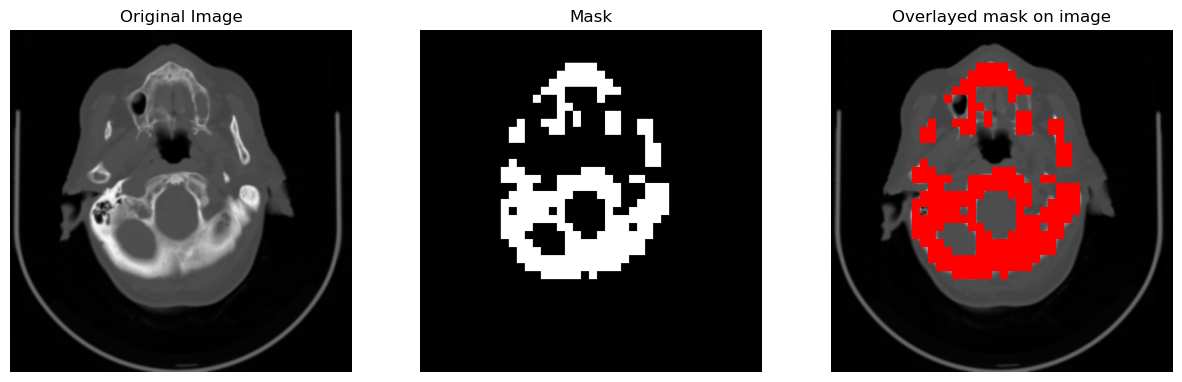

In [26]:
# Function to identify ROI based on superpixels
def identify_roi(image, segments, intensity_threshold):
    """
    Identifies Regions of Interest (ROI) in an image based on superpixel segmentation.
    
    Parameters:
    - image (np.ndarray): The input grayscale image.
    - segments (np.ndarray): The labels of superpixels.
    - intensity_threshold (float): The intensity threshold to identify ROI.
    
    Returns:
    - np.ndarray: Binary mask of the ROI.
    """
    unique_labels = np.unique(segments)
    roi_mask = np.zeros_like(image, dtype=np.uint8)

    for label in unique_labels:
        mask = (segments == label)
        superpixel_values = image[mask]
        mean_intensity = np.mean(superpixel_values)

        if mean_intensity > intensity_threshold:
            roi_mask[mask] = 255

    return roi_mask

# Apply SLIC algorithm with optimal N
optimal_segments = slic(pixel_data_uint8, n_segments=1750, sigma=1)

intensity_threshold = 90 
roi_mask = identify_roi(pixel_data_uint8, optimal_segments, intensity_threshold)

visualize(pixel_data_uint8, roi_mask)